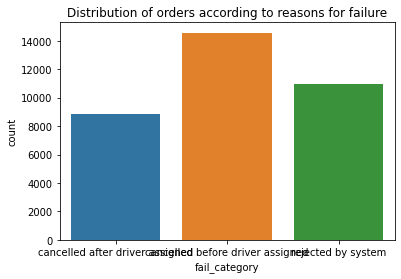

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# load data sets
orders = pd.read_csv("data_orders.csv")
offers = pd.read_csv("data_offers.csv")

# merge data sets on order_gk
data = pd.merge(orders, offers, on="order_gk", how="left")
df = orders.merge(right=offers, how="inner", on="order_gk")
df.sample(n=10, random_state=42)
# define a function to categorize failed orders
def categorize_fail(row):
    if row["order_status_key"] == 4:
        if row["is_driver_assigned_key"] == 1:
            return "cancelled after driver assigned"
        else:
            return "cancelled before driver assigned"
    elif row["order_status_key"] == 9:
        return "rejected by system"
    else:
        return "not failed"

# categorize failed orders
data["fail_category"] = data.apply(lambda row: categorize_fail(row), axis=1)

# plot distribution of orders according to reasons for failure
sns.countplot(x="fail_category", data=data)
plt.title("Distribution of orders according to reasons for failure")
plt.show()




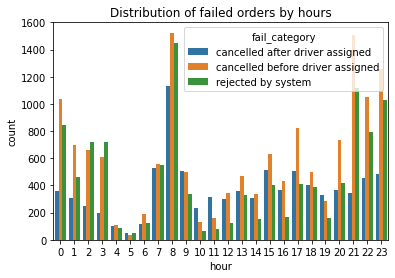

In [14]:
# plot distribution of failed orders by hours
data["hour"] = pd.to_datetime(data["order_datetime"]).dt.hour
sns.countplot(x="hour", hue="fail_category", data=data)
plt.title("Distribution of failed orders by hours")
plt.show()


In [15]:

df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Yes", "No")
df["order_status"] = np.where(df["order_status_key"] == 4, "Client Cancelled", "System Reject")

df.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace=True)
df = df.rename(columns={
    "order_datetime": "order_time"
})
df["order_hour"] = df["order_time"].str.split(":").apply(lambda split: split[0])
grouped_q3 = df.groupby(by=["order_hour", "is_driver_assigned"])["cancellations_time_in_seconds"].mean()
grouped_q3


order_hour  is_driver_assigned
00          No                    115.126437
            Yes                   276.082822
01          No                    100.593997
            Yes                   296.312081
02          No                    121.305461
            Yes                   301.466667
03          No                    129.182301
            Yes                   368.682051
04          No                    100.733333
            Yes                   245.250000
05          No                    102.838710
            Yes                   156.617021
06          No                    202.952663
            Yes                   225.508772
07          No                    141.177820
            Yes                   177.640232
08          No                    132.625432
            Yes                   172.896296
09          No                    138.014894
            Yes                   230.821862
10          No                     93.795082
            Yes         

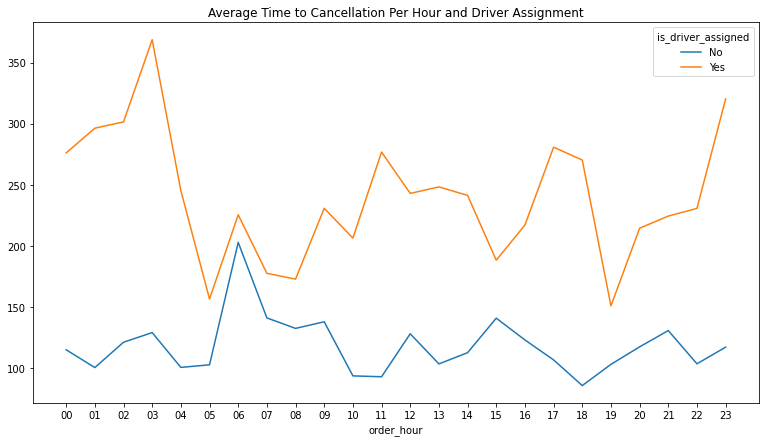

In [16]:
_ = grouped_q3.reset_index().pivot(index="order_hour",
                                   columns="is_driver_assigned",
                                   values="cancellations_time_in_seconds").plot(xticks=range(0, 24),
                                                                                figsize=(13, 7),
                                                                                title="Average Time to Cancellation Per Hour and Driver Assignment")

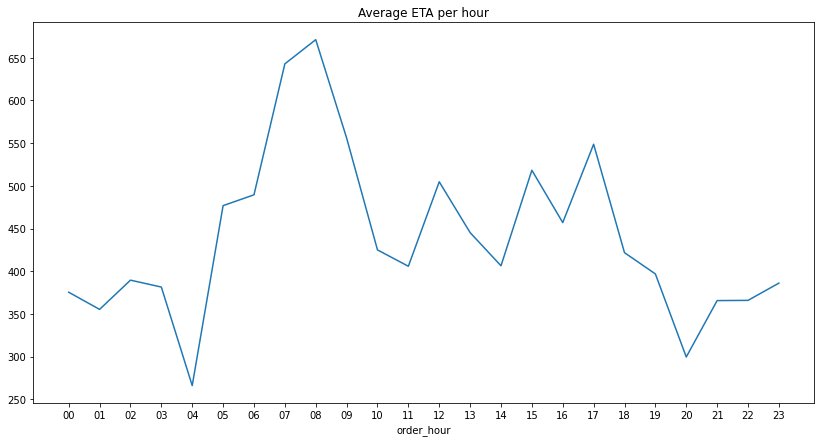

In [17]:
_ = df.groupby(by="order_hour")["m_order_eta"].mean().plot(figsize=(14, 7),
                                                           xticks=range(0, 24),
                                                           title="Average ETA per hour")

In [26]:
!pip install geojson
!pip install h3

import h3
import folium

# create a folium map with the average latitude and longitude of the origin
map = folium.Map(location=[df["origin_latitude"].mean(), df["origin_longitude"].mean()],
                 zoom_start=8.5,
                 tiles="cartodbpositron")

# convert latitude and longitude to h3 hexagonal grid with resolution 8
df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(lat=row["origin_latitude"],
                                                  lng=row["origin_longitude"],
                                                  resolution=8), axis=1)

# count the number of orders in each hexagonal grid cell
grouped = df.groupby(by="hex_id")["order_gk"].count().reset_index()

# define a function to convert hex_id to geojson object
def to_geojson(row):
    geometry = {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]
    }
    return geojson.Feature(id=row["hex_id"], geometry=geometry, properties={"order_gk": row["order_gk"]})

# apply the to_geojson function to the grouped data and create a geojson string
geojsons = grouped.apply(to_geojson, axis=1).values.tolist()
geojson_str = json.dumps(geojson.FeatureCollection(geojsons))

# add the geojson string to the folium map and color the cells according to the number of orders
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
    "fillColor": matplotlib.colors.to_hex(
        colormap((f["properties"]["order_gk"] - min_order_gk) / (max_order_gk - min_order_gk))),
    "color": "black",
    "weight": 1,
    "fillOpacity": 0.7
}).add_to(map)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
map